In [72]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
import tensorflow as tf
import keras
from tensorflow.keras import layers
#from tensorflow.compat.v1.train.AdamOptimizer import Adam
#from keras.optimizers.Adam import Adam

In [73]:
Adam = tf.compat.v1.train.AdamOptimizer

In [74]:
data_dir = 'images/train2'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'
test_data_portion = 0.1
val_data_portion = 0.1
nb_images = 351 

In [76]:
import shutil, sys  
def create_directory (dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, "man"))
    os.makedirs(os.path.join(dir_name, "woman"))

In [77]:
import os
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

In [78]:
def copy_images (start_index, end_index,source_dir, dest_dir):
    for i in range (start_index, end_index):
        shutil.copy2(os.path.join(source_dir, "man."+str(i) + ".jpg"),
                    os.path.join(dest_dir, "man"))
        shutil.copy2(os.path.join(source_dir, "woman."+ str(i)+ ".jpg"),
                    os.path.join(dest_dir, "woman"))

In [79]:
start_val_data_idx = int(nb_images * (1 - val_data_portion - test_data_portion))
start_test_data_idx = int(nb_images * (1 - test_data_portion))
print(start_val_data_idx)
print(start_test_data_idx)

280
315


In [80]:
copy_images(0, start_val_data_idx, data_dir,train_dir)
copy_images(start_val_data_idx, start_test_data_idx,data_dir,val_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

In [81]:
base_model = applications.VGG19(weights='imagenet', include_top=False)

In [82]:
base_model.trainable = False

In [83]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [85]:
# Добавляем слои классификации
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# Выходной слой с двумя нейронами для классов "man" и "women"
predictions = Dense(2, activation='softmax')(x)

In [86]:
# Составляем сеть из двух частей
model = Model(inputs=base_model.input, outputs=predictions)

In [87]:
# "Замораживаем" сверточные уровни сети VGG19
# Обучаем только вновь добавленные слои
for layer in base_model.layers:
    layer.trainable = False

In [88]:
# Компилируем модель
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
# Размер изображений
img_width, img_height = 224, 224
# Путь к каталогу с изображениями для обучения
train_data_dir = 'train'
# Путь к каталогу с изображениями для валидации
validation_data_dir = 'val'
test_data_dir ='test'
# Количество изображений для обучения
nb_train_samples = 280
# Количество изображений для валидации
nb_validation_samples = 10
# Количество эпох
epochs = 7
# Размер выборки
batch_size = 5

In [90]:
# Создаем генератор данных для обучения
datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= 'categorical')

Found 560 images belonging to 2 classes.


In [91]:
# Создаем генератор данных для валидации
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= 'categorical')

Found 70 images belonging to 2 classes.


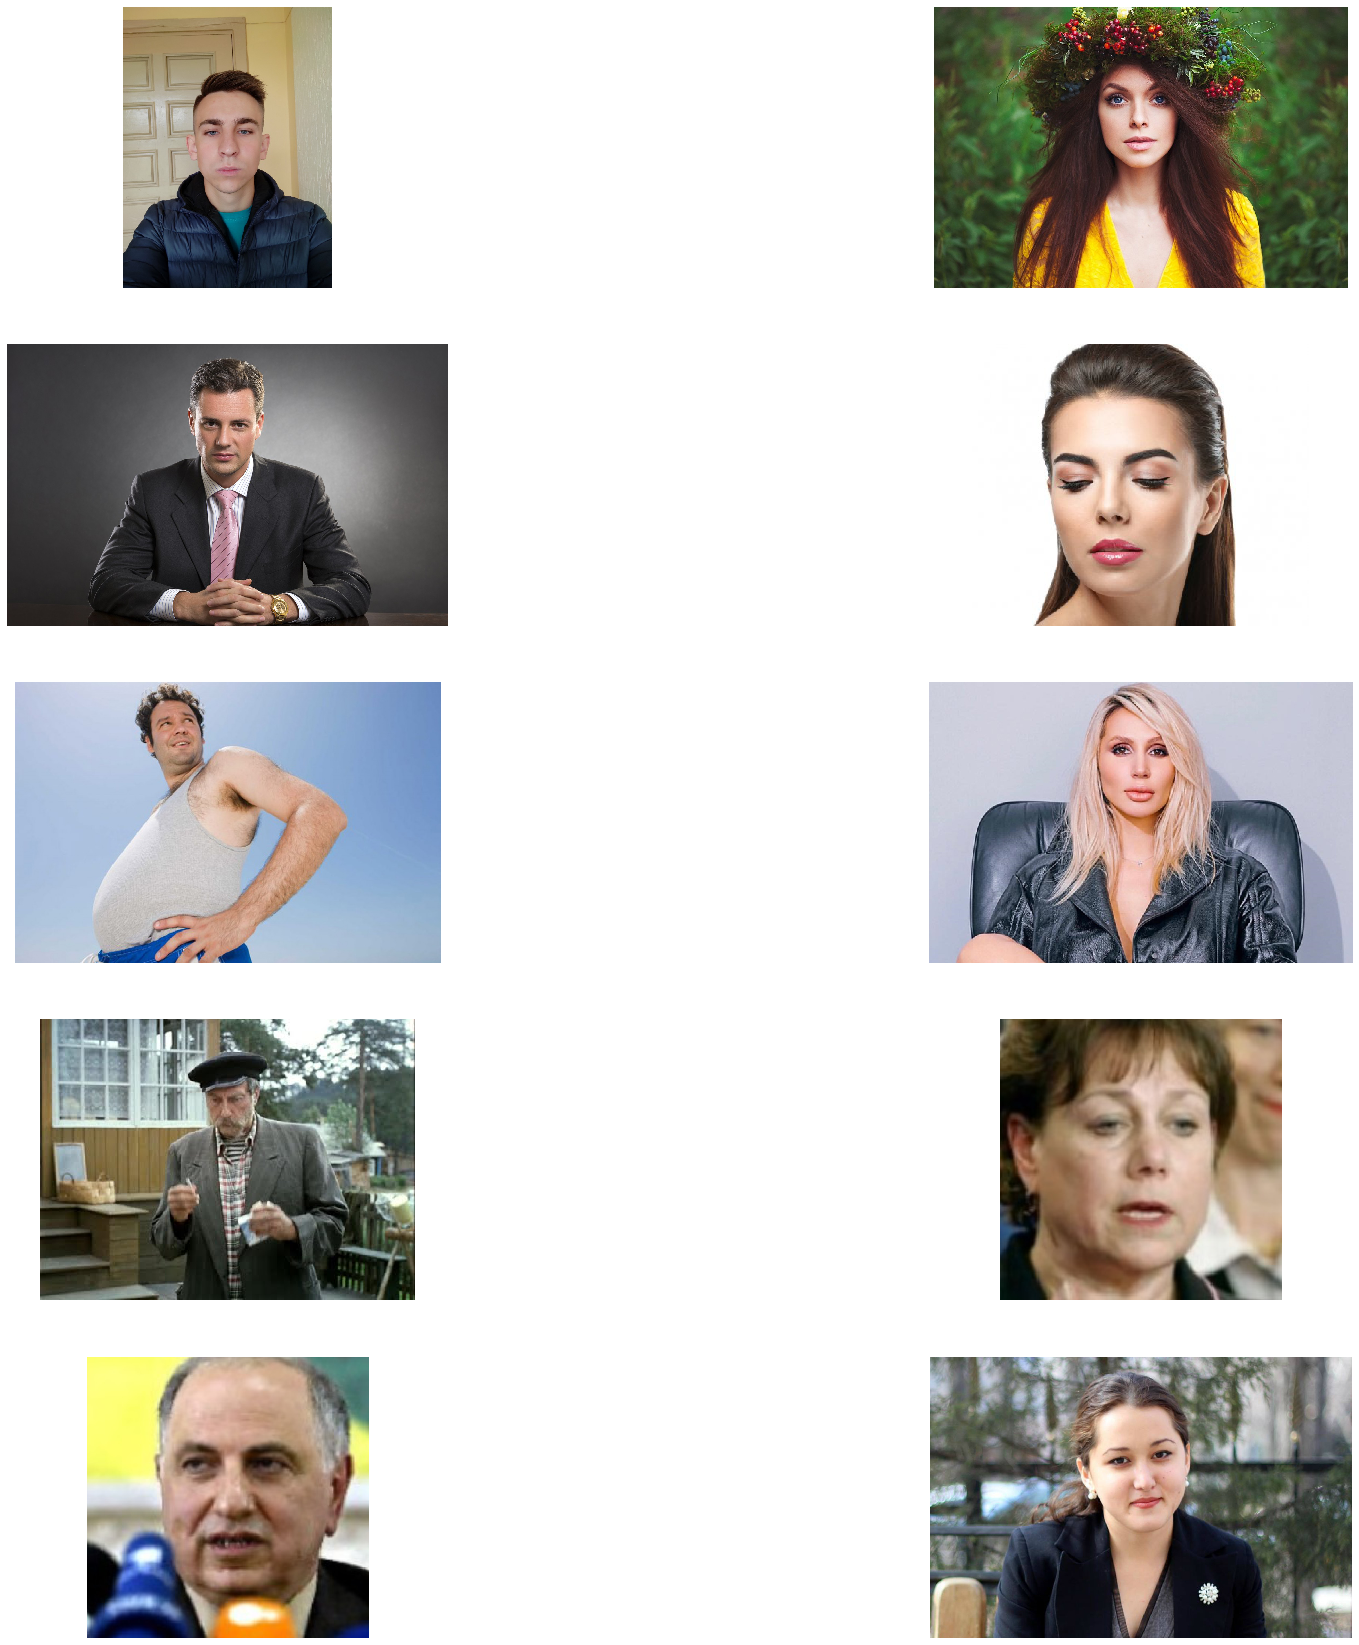

In [92]:
import random
import matplotlib.pyplot as plt
from PIL import Image
sample = []
num_imgs_per_class = 5
for i in range(num_imgs_per_class):
    for folder in os.listdir(train_dir):
        sample.append(os.path.join(
            train_dir+"/"+folder,random.choice(os.listdir(train_dir+"/"+folder))))

# plotting some images to know the data
plt.figure(figsize=(30,30))
for n in range(len(sample)):
  plt.subplot(5,2,n+1)
  plt.imshow(Image.open(sample[n]))
  plt.axis('off')

In [93]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [94]:
# Обучаем модель с помощью генератора
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = nb_validation_samples)

Epoch 1/7
280/280 [==============================] - 104s 373ms/step - loss: 0.7401 - accuracy: 0.5986 - val_loss: 0.9825 - val_accuracy: 0.6200
Epoch 2/7
280/280 [==============================] - 108s 387ms/step - loss: 0.5851 - accuracy: 0.6950 - val_loss: 0.5275 - val_accuracy: 0.5600
Epoch 3/7
280/280 [==============================] - 107s 383ms/step - loss: 0.5078 - accuracy: 0.7514 - val_loss: 0.3177 - val_accuracy: 0.5800
Epoch 4/7
280/280 [==============================] - 108s 385ms/step - loss: 0.4820 - accuracy: 0.7836 - val_loss: 0.8823 - val_accuracy: 0.7000
Epoch 5/7
280/280 [==============================] - 109s 389ms/step - loss: 0.4506 - accuracy: 0.7957 - val_loss: 0.5137 - val_accuracy: 0.6600
Epoch 6/7
280/280 [==============================] - 109s 388ms/step - loss: 0.4514 - accuracy: 0.8036 - val_loss: 0.9607 - val_accuracy: 0.6600
Epoch 7/7
280/280 [==============================] - 108s 384ms/step - loss: 0.4256 - accuracy: 0.8057 - val_loss: 0.6971 - val_ac

In [95]:
# Загружаем изображение 
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
img = image.load_img('t2.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

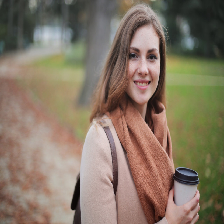

In [96]:
img

In [97]:
preds = model.predict(x)
print('Результаты распознавания:', preds)

Результаты распознавания: [[0. 1.]]


In [98]:
model.trainable = True
trainable = False
for layer in model.layers:
    if layer.name =='block5_conv1':
        trainable = True
    layer.trainable = trainable

In [99]:
model.compile(loss='binary_crossentropy', 
             optimizer = tf.keras.optimizers.Adam( learning_rate = 1e-5),
             metrics=['accuracy'])


In [100]:
epochs = 3
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = nb_validation_samples)

Epoch 1/3
280/280 [==============================] - 145s 519ms/step - loss: 0.2206 - accuracy: 0.9071 - val_loss: 0.1979 - val_accuracy: 0.6800
Epoch 2/3
280/280 [==============================] - 145s 517ms/step - loss: 0.0292 - accuracy: 0.9936 - val_loss: 0.0097 - val_accuracy: 0.7800
Epoch 3/3
280/280 [==============================] - 147s 525ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.9561 - val_accuracy: 0.7200


In [101]:
# Загружаем изображение 
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
img = image.load_img('person_0965.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

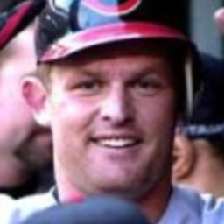

In [102]:
img

In [103]:
preds = model.predict(x)
print('Результаты распознавания:', preds)

Результаты распознавания: [[1. 0.]]


In [107]:
batch_size = 1
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= 'categorical')


Found 72 images belonging to 2 classes.


In [108]:
scores = model.evaluate(test_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))

72/72 [==============================] - 5s 72ms/step
Accuracy: 83.33%


In [33]:
model.save('model.h5')

C:\Users\Timofey\Anaconda3\envs\tensorwlow\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')
